In [2]:
import pandas as pd

import pandas as pd
import numpy as np 
import missingno as mno
import pickle 
import json
import time 
import gc
import random
import sklearn

#For Data Visualization
import matplotlib.pyplot as plt
#%matplotlib inline 
#output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]

import networkx as nx
import plotly.express as px 
import plotly.graph_objects as go #To construct network graphs
from plotly.subplots import make_subplots #To make multiple plots

#To avoid printing of un necessary Deprecation warning and future warnings!
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from plotly.offline import init_notebook_mode, iplot
from IPython.core.display import display, HTML #To display html content in a code cell
init_notebook_mode(connected=True)

gc.collect()

0

In [22]:
sol = pd.read_csv("solana.csv")
bnb = pd.read_csv("BNB.csv")

In [23]:
#data preprocessing
df = sol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      449 non-null    object 
 1   Open      449 non-null    float64
 2   High      449 non-null    float64
 3   Low       449 non-null    float64
 4   Close     449 non-null    float64
 5   Volume    449 non-null    int64  
 6   Currency  449 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 24.7+ KB


In [24]:
df = bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748 entries, 0 to 1747
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1748 non-null   object 
 1   Open      1748 non-null   float64
 2   High      1748 non-null   float64
 3   Low       1748 non-null   float64
 4   Close     1748 non-null   float64
 5   Volume    1748 non-null   float64
 6   Currency  1748 non-null   object 
dtypes: float64(5), object(2)
memory usage: 95.7+ KB


In [20]:
def candle_stick(df,name):
    data=df
    
    fig = go.Figure(data=go.Ohlc(x=data['Date'],
                    open=data['Open'],
                    high=data['High'],
                    low=data['Low'],
                    close=data['Close']))

    fig.update_layout(template='plotly_dark',
        title='{} Price'.format(name),
        xaxis_title="Date",
        yaxis_title='{} Price'.format(name),title_x=0.5,
        )
    fig.update_yaxes( # the y-axis is in dollars
        tickprefix="$", showgrid=False
    )

    fig.update_xaxes(
         showgrid=True
    )
    
    low=[data['Open'].min(),data['High'].min(),data['Low'].min(),data['Close'].min()]
    high=[data['Open'].max(),data['High'].max(),data['Low'].max(),data['Close'].max()]
    
    fig.show()
    
    display(HTML('<div style="color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:100%;font-family:Verdana;letter-spacing:0.5px;text-align:center"><p style="padding: 10px;color:white;"><center><b> {} Summary :<center></b></p><br>Median price: {}<br>Mean price: {}<br>Highest price: {}<br>Lowest price: {}<br></div>'.format(name,data['Close'].median(),data['Close'].mean(),max(high),min(low))))

In [25]:
candle_stick(sol,'SOLANA')

In [26]:
candle_stick(bnb,'BNB')

In [38]:
def mom_growth_rate(final_df,name):
    final_df['Date']=pd.to_datetime(final_df['Date'],format="%Y-%m-%d")
    final_df['Year']=final_df['Date'].dt.year
    final_df['Month']=final_df['Date'].dt.month
    final_df['Coin_name']=name
    year_df=final_df[(final_df['Year']==2021)&(final_df['Month']!=11)]
    group_yr_df=year_df.groupby(['Coin_name','Month']).agg({'Close':np.mean}).reset_index()

    def mom(m1,m2):
        return round(((m2-m1)/m1)*100,2)

    mom_list=[]
    for i in list(group_yr_df['Coin_name'].unique()):
        df=group_yr_df[group_yr_df['Coin_name']==i]
        for j in range(0,len(df)):
            if df['Month'].iloc[j]!=1:
                mom_list.append(mom(df['Close'].iloc[j-1],df['Close'].iloc[j]))
            else:
                 mom_list.append(0)

    group_yr_df['mom']=mom_list

    group_yr_df['mom']=round(group_yr_df['mom'],2)
    df2=group_yr_df.pivot_table(index='Coin_name',columns='Month',values='mom')

    def style_negative(v, props=''):
        return props if v < 0 else None
    s2 = df2.style.applymap(style_negative, props='color:red;')\
                  .applymap(lambda v: 'opacity: 20%;' if (v < 0.3) and (v > -0) else None)

    def highlight_max(s, props=''):
        return np.where(s == np.nanmax(s.values), props, '')
    s2.apply(highlight_max, props='color:white;background-color:darkblue', axis=1)

    s2.set_caption("Mean Price Month on Month (MOM) Growth rate")\
     .set_table_styles([{
         'selector': 'caption',
         'props': 'caption-side: top; font-size:2.50em;'
     }], overwrite=False)
    
    mon_year=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov']
    fig=px.line(group_yr_df,x='Month',y='mom',color='Coin_name')
    fig.update_layout(template='plotly_dark',
            title='Mean Price Month on Month (MOM) Growth rate -2021',
            xaxis_title="Month in 2021",
            yaxis_title='MoM growth percentage',title_x=0.5,
            )
    fig.update_yaxes( # the y-axis is in dollars
        tickprefix="%", showgrid=False
    )
    fig.update_xaxes(
         showgrid=True
    )
    fig.show()
    
    return df2
    

In [39]:
mom_growth_rate(sol,'SOLANA')

Month,1,2,3,4,5,6,7,8
Coin_name,,,,,,,,
SOLANA,0.0,197.54,52.92,111.0,27.36,-10.57,-14.85,84.67


In [40]:
mom_growth_rate(bnb,'BNB')

Month,1,2,3,4,5,6,7,8,9,10,12
Coin_name,,,,,,,,,,,
BNB,0.0,277.66,65.36,87.66,1.08,-31.27,-9.92,34.62,-0.72,13.12,19.2


In [41]:
def moving_average(df,name,period1,period2):
    #Closing price 
    adj_close_px = df['Close']
    
    df['Rolling 42'] = adj_close_px.rolling(window=period1).mean()
    df['Rolling 252'] = adj_close_px.rolling(window=period2).mean()
    df[['Close', 'Rolling 42', 'Rolling 252']].plot()
    
    plt.title('Moving average of {}'.format(name))
    plt.ylabel('Price')
    
    
    plt.show()

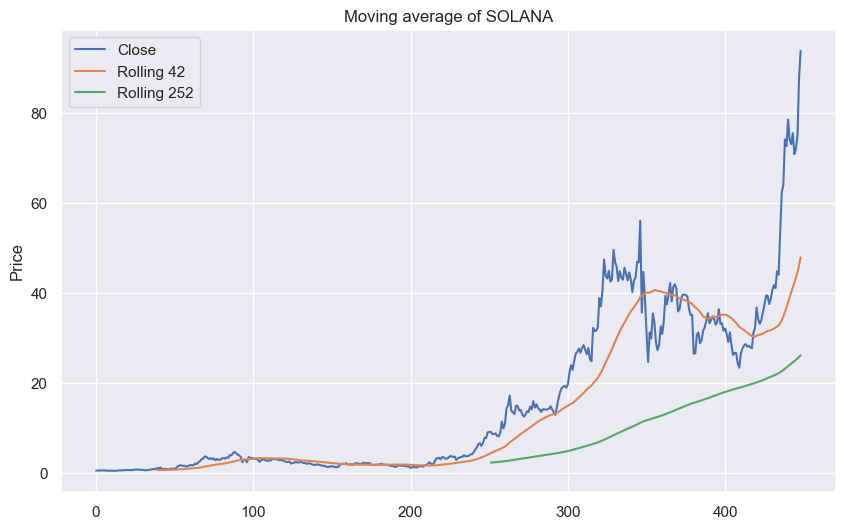

In [42]:
moving_average(sol,'SOLANA',40,252)

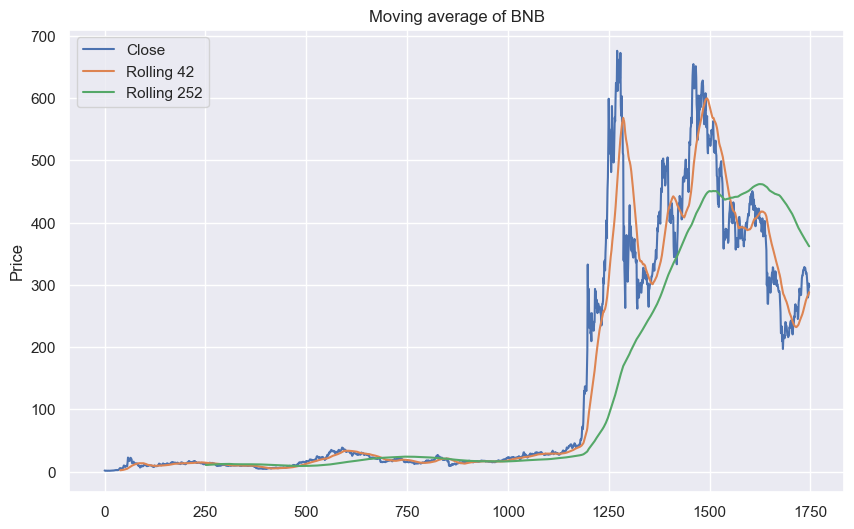

In [43]:
moving_average(bnb,'BNB',40,252)

In [46]:
def sma_and_ema(df,name):
    df['SMA5'] = df.Close.rolling(5).mean()
    df['SMA20'] = df.Close.rolling(20).mean()
    df['SMA50'] = df.Close.rolling(50).mean()
    df['SMA200'] = df.Close.rolling(200).mean()
    df['SMA500'] = df.Close.rolling(500).mean()

    fig = go.Figure(data=[go.Ohlc(x=df['Date'],open=df['Open'],high=df['High'],low=df['Low'],close=df['Close'], name = "OHLC"),
                          go.Scatter(x=df.Date, y=df.SMA5, line=dict(color='orange', width=1), name="SMA5"),
                          go.Scatter(x=df.Date, y=df.SMA20, line=dict(color='green', width=1), name="SMA20"),
                          go.Scatter(x=df.Date, y=df.SMA50, line=dict(color='blue', width=1), name="SMA50"),
                          go.Scatter(x=df.Date, y=df.SMA200, line=dict(color='violet', width=1), name="SMA200"),
                          go.Scatter(x=df.Date, y=df.SMA500, line=dict(color='purple', width=1), name="SMA500")])
    
    fig.update_layout(template='plotly_dark',
        xaxis_title='Date',
        yaxis_title='Price',
        title='SMA of {}'.format(name),
        hovermode="x",title_x=0.5
    )
    
    fig.update_yaxes( # the y-axis is in dollars
        tickprefix="$", showgrid=True
    )

    fig.update_xaxes(
         showgrid=True
    )
    
    fig.show()


    df['EMA5'] = df.Close.ewm(span=5, adjust=False).mean()
    df['EMA20'] = df.Close.ewm(span=20, adjust=False).mean()
    df['EMA50'] = df.Close.ewm(span=50, adjust=False).mean()
    df['EMA200'] = df.Close.ewm(span=200, adjust=False).mean()
    df['EMA500'] = df.Close.ewm(span=500, adjust=False).mean()

    fig = go.Figure(data=[go.Ohlc(x=df['Date'],
                                  open=df['Open'],
                                  high=df['High'],
                                  low=df['Low'],
                                  close=df['Close'], name = "OHLC"),
                          go.Scatter(x=df.Date, y=df.EMA5, line=dict(color='orange', width=1), name="EMA5"),
                          go.Scatter(x=df.Date, y=df.EMA20, line=dict(color='green', width=1), name="EMA20"),
                          go.Scatter(x=df.Date, y=df.EMA50, line=dict(color='blue', width=1), name="EMA50"),
                          go.Scatter(x=df.Date, y=df.EMA200, line=dict(color='violet', width=1), name="EMA200"),
                          go.Scatter(x=df.Date, y=df.EMA500, line=dict(color='purple', width=1), name="EMA500")])
    fig.update_layout(template='plotly_dark',
        xaxis_title='Date',
        yaxis_title='Price',
        title='EMA of {}'.format(name),
        hovermode="x",title_x=0.5
    )
    fig.update_yaxes( # the y-axis is in dollars
        tickprefix="$", showgrid=True
    )
    
    fig.update_xaxes(
         showgrid=True
    )
    
    fig.show()

In [47]:
sma_and_ema(sol,'SOLANA')

In [48]:
sma_and_ema(bnb,'BNB')

In [51]:
sol_vol=pd.DataFrame(sol[sol['Year']==2021].groupby(['Month']).agg({'Volume':np.mean}).reset_index())
bnb_vol=pd.DataFrame(bnb[bnb['Year']==2021].groupby(['Month']).agg({'Volume':np.mean}).reset_index())

plt_df=sol_vol[['Month','Volume']].merge(bnb_vol[['Month','Volume']],on='Month',how='left')[0:-1]
plt_df.rename(columns={'Volume_x':'SOLANA','Volume_y':'BNB'},inplace=True)
fig = px.line(plt_df, x='Month', y=['SOLANA','BNB'])
fig.update_layout(template='plotly_dark',
    xaxis_title='Month',
    yaxis_title='Mean trading volume',
    title='Mean trading volume of SOLANA and BNB in 2021',
    hovermode="x",title_x=0.5
)
fig.update_yaxes( # the y-axis is in dollars
    tickprefix="$", showgrid=True
)

fig.update_xaxes(
     showgrid=True
)
fig.show()
